# Machine Learning Materials Properties

This notebook is intended as an introductory how-to on training a model on materials properties based upon SOAP vectors. For more information on the variable conventions, derivation, utility, and calculation of SOAP vectors, please refer to (among others):

<ul>
  <li> <a href="https://journals.aps.org/prb/abstract/10.1103/PhysRevB.87.184115">On representing chemical environments (Bartók 2013)</a></li>
  <li><a href="https://onlinelibrary.wiley.com/doi/full/10.1002/qua.24927">Gaussian approximation potentials: A brief tutorial introduction (Bartók 2015)</li>
  <li><a href="https://pubs.rsc.org/en/content/articlepdf/2016/cp/c6cp00415f">Comparing molecules and solids across structural and alchemical space (De 2016)</li>
    <li><a href="https://link.springer.com/content/pdf/10.1007%2F978-3-319-42913-7_68-1.pdf">Machine Learning of Atomic-Scale Properties Based on Physical Principles (Ceriotti 2018)</li>
</ul>

Beyond libRascal, the packages used in this tutorial are:  [json](https://docs.python.org/2/library/json.html), [numpy](https://numpy.org/), [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/), [matplotlib](https://matplotlib.org/), and [ase](https://wiki.fysik.dtu.dk/ase/index.html).

In [1]:
%matplotlib inline

# may omit in final version
%reload_ext autoreload
%autoreload 2 

import os
import time
import sys

import numpy as np
import ase
from ase.io import read
from matplotlib import pyplot as plt
import json

sys.path.append('./utilities')

reference_dir = '../../../reference_data'
    
from general_utils import *
from rascal.representations import SphericalInvariants as SOAP
from rascal.models import Kernel

## Training a Kernel Ridge Regression (KRR) on Global Properties
As discussed in [Link to Hyperparameter Tutorial](), the hyperparameters of a SOAP descriptor will decide the amount of information contained in the descriptor. Here we'll use a standard Power Spectrum SOAP representation:

### Hyperparameters

In [2]:
hyperparameters = dict(soap_type = 'PowerSpectrum', \
                       interaction_cutoff = 3.5, \
                       max_radial = 6, \
                       max_angular = 6, \
                       gaussian_sigma_constant = 0.4, \
                       gaussian_sigma_type = 'Constant', \
                       cutoff_smooth_width = 0.5
                      )

### Load and Read the Input File
We'll first look at the [small_molecules-1000.xyz]() file, which contains the per-atom formation energy in eV. Because this is a property of the crystal (opposed to the atoms), we'll want to use the "Structure" kernel given by libRascal.

In [3]:
input_file = f'{reference_dir}/inputs/small_molecules-1000.xyz'
property_name = "dft_formation_energy_per_atom_in_eV"

We then read the trajectory, store the desired property, and create our SOAP calculator.

In [4]:
frames = np.array(read(input_file,":100"))
number_of_frames = len(frames)
print(f"There are {number_of_frames} frames.")
property_values = np.array([cc.info[property_name] for cc in frames])

representation = SOAP(**hyperparameters)

There are 100 frames.


### Preparing Data for KRR

We also need to define a few parameters for our training model:
<ul>
  <li> <b>training percentage</b>: (float) percent of frames to train the model on</li>
  <li> <b>$\zeta$</b>: (int) order the dot kernel</li>
  <li> <b>$\Lambda$</b>: (float) error for the <a href="https://en.wikipedia.org/wiki/Tikhonov_regularization">Tikhonov Regularization</a></li>
  <li> <b>jitter</b>: (float) threshold for zero eigenvalues </li>
  <li> <b>kernel_type</b>: (string, "Atom" or "Structure") whether to compare the environmental or average features.
</ul>

We also need to split our dataset into a [training and testing set](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets).

In [5]:
training_percentage = 0.8
zeta = 2
Lambda = 5e-3
jitter = 1e-8
kernel_type = "Structure"

In [6]:
def split_dataset(N, training_percentage, seed=20):
    np.random.seed(seed)
    ids = list(range(N))
    np.random.shuffle(ids)
    return ids[:int(training_percentage*N)], ids[int(training_percentage*N):]

train_idx, test_idx = split_dataset(number_of_frames, training_percentage)

Now we're ready to train the model! We can use our SOAP calculator to compute the features of our training set.

In [7]:
features = representation.transform(frames[train_idx])

### Constructing the KRR and Predicting the Properties

We'll construct a KRR object so that we can reuse the model.

In [8]:
class KRR(object):
    
    def __init__(self, features, properties,
                 kernel_type, representation, 
                 Lambda, jitter, zeta=2,
                 weights=None, kernel_name="Cosine",
                 **kwargs):
        
        self.weights = weights
        
        self.X = features
        self.Y = properties
        
        self.kernel = Kernel(representation=representation, name=kernel_name,
                             target_type=kernel_type, zeta=zeta, **kwargs)

        self.Lambda = Lambda
        self.jitter = jitter
        self.hypers = dict(**kwargs)
        self.calculator = representation

    def train(self):
        KXX = self.kernel(self.X, self.X)

        delta = np.std(self.Y) / np.mean(KXX.diagonal())
        KXX[np.diag_indices_from(KXX)] += self.Lambda**2 / delta **2 + self.jitter
        
        self.weights = np.linalg.solve(KXX,self.Y)
        self.trained = True
        
    def predict(self, frames):
        
        try:
            print(f"Our weights have been calculated and have shape {self.weights.shape}")
        except:
            self.train()
        
        features = self.calculator.transform(frames)
        
        kernel = self.kernel(self.X, features)
        
        return np.dot(self.weights, kernel)
    
    def plot(self, y_known, property_name, frames=None, y=None):
        def calc_R2(yk, yp):
            SStot = ((yk - np.average(yk, axis=0)) ** 2).sum(axis=0,dtype=np.float64)
            SSres = ((yk - yp) ** 2).sum(axis=0,dtype=np.float64)
            return np.mean(1 - (SSres/SStot))
        if(frames!=None):
            y=self.predict(frames)

        stats = dict(
                    mean_average_error= [np.mean(np.abs(y-y_known))],
                    root_mean_squared_error=[np.sqrt(np.mean((y-y_known)**2))],
                    R2 = [calc_R2(y_known, y)]
                    )
        headers = ['Statistic', 'Value']
        
        display(Markdown(markdown_table_from_dict(stats, headers)))
        
        plt.scatter(y, y_known, s=3)
        plt.axis('scaled')
        plt.xlabel(property_name)
        plt.ylabel('Predicted '+property_name)
        plt.gca().set_aspect('equal')
        plt.show()

### Constructing the Kernel
libRascal provides different kernels through the rascal.models.Kernel class.

Here we'll use the cosine kernel, which uses the $\zeta$ parameter we defined earlier. The cosine kernel is defined as:

\begin{equation}
k(x, y) = \left(\frac{xy^T}{||x|| ||y||}\right)^\zeta
\end{equation}

A Kernel object can be called on a single feature (to give the self-kernel) or a pair of features.

In [9]:
krr = KRR(features, property_values[train_idx],
          kernel_type=kernel_type, representation=representation,
          Lambda=Lambda, jitter=jitter, weights=None,
          zeta=zeta, **hyperparameters
         )

### Training the KRR
We must find the kernel K of our training features and adjust it by the [Tikhonov matrix](https://en.wikipedia.org/wiki/Tikhonov_regularization). 

The weights $w$ are then the solutions of:

\begin{equation}
K w = Y
\end{equation}

where Y is the property matrix.

In [10]:
krr.train()

### Predicting Properties using the KRR

Our weights have been calculated and have shape (80,)


<table>  <thead><tr><th>Statistic</th><th>Value</th></tr></thead><tbody><tr><td>Mean Average Error</td><td>0.032</td></tr><tr><td>Root Mean Squared Error</td><td>0.0448</td></tr><tr><td>R2</td><td>0.9178</td></tr></tbody></table>

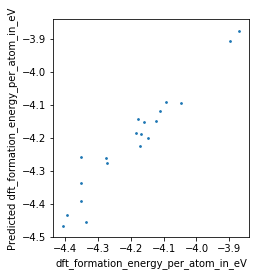

In [11]:
y = krr.predict(frames[test_idx])
krr.plot(y_known=property_values[test_idx], y=y, property_name=property_name)

### Predicting from Another Data Set

Our weights have been calculated and have shape (80,)


<table>  <thead><tr><th>Statistic</th><th>Value</th></tr></thead><tbody><tr><td>Mean Average Error</td><td>0.0331</td></tr><tr><td>Root Mean Squared Error</td><td>0.0523</td></tr><tr><td>R2</td><td>0.904</td></tr></tbody></table>

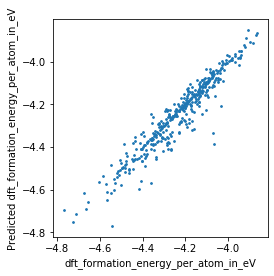

In [12]:
filename=f'{reference_dir}/inputs/small_molecules-1000.xyz'
new_frames = read(filename,":400")
new_property_values = np.array([cc.info[property_name] for cc in new_frames])
y_pred = krr.predict(new_frames)

krr.plot(y_known=new_property_values, y=y_pred, property_name=property_name)

## Training a KRR on Atomic Properties
Now let's consider a property that is atom-centric, like the chemical shift. The workflow of predicting this property does not change much--we can use the same hyperparaters and Kernel class--but we will note the changes.

### Load and Read the Input File
We'll now look at the [CSD-500.xyz](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-018-06972-x/MediaObjects/41467_2018_6972_MOESM4_ESM.txt) file, which contains the chemical shifts (CS) of 500 molecules. Because this is a property of the atoms, we'll want to use the "Structure" kernel given by libRascal.

Because CSD-500 is a larger file, we don't automatically include it in the rascal repo, but it can be downloaded when needed:

In [13]:
download_link = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-018-06972-x/MediaObjects/41467_2018_6972_MOESM4_ESM.txt"
if(not os.path.exists(f'{reference_dir}/inputs/CSD-500.xyz')):
    print("Downloading CSD-500")
    import urllib.request
    urllib.request.urlretrieve(download_link, f'{reference_dir}/inputs/CSD-500.xyz')

In [14]:
input_file = f'{reference_dir}/inputs/CSD-500.xyz'
property_name = "CS"

We then read the trajectory, store the desired property, and create our SOAP calculator.

**Because the chemical shifts are per-atom properties, they have been stored in ase.arrays, as opposed to ase.info.**

In [15]:
frames = np.array(read(input_file,":100"))
for frame in frames:
    frame.wrap()
number_of_frames = len(frames)
property_values = np.array([cc.arrays[property_name] for cc in frames])
print(f"There are {number_of_frames} frames and {len(np.concatenate(property_values))} environments.")

representation = SOAP(**hyperparameters)

There are 100 frames and 13233 environments.


### Preparing Data for KRR

We still need to define the training percentage, $\zeta$, $\Lambda$, jitter, and the kernel_type, **however only the kernel_type will differ from the earlier example**. We can then split our dataset into training and testing sets and calculate the SOAP vectors.

In [16]:
kernel_type = "Atom"
train_idx, test_idx = split_dataset(number_of_frames, training_percentage)

In [17]:
features = representation.transform(frames[train_idx])

### Constructing the KRR and Predicting the Properties

The only change here is the properties array. **Because the properties are stored in lists for each molecule, we will need to pass the concatenated list of the properties to our KRR model.**

In [18]:
krr = KRR(features, np.concatenate(property_values[train_idx]),
          kernel_type=kernel_type, representation=representation,
          Lambda=Lambda, jitter=jitter, weights=None,
          zeta=zeta, **hyperparameters
         )

### Training the KRR

In [19]:
krr.train()

In [20]:
y = krr.predict(frames[test_idx])

Our weights have been calculated and have shape (10758,)


<table>  <thead><tr><th>Statistic</th><th>Value</th></tr></thead><tbody><tr><td>Mean Average Error</td><td>11.3629</td></tr><tr><td>Root Mean Squared Error</td><td>21.0725</td></tr><tr><td>R2</td><td>0.9145</td></tr></tbody></table>

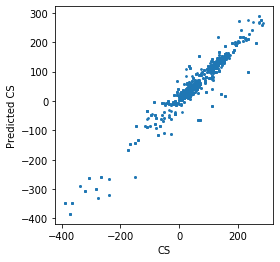

In [21]:
krr.plot(y_known=np.concatenate(property_values[test_idx]),
         y=y, property_name=property_name)